In [225]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

import h5py
from scipy.fft import rfft, rfftfreq

from scipy.signal.windows import hann
from scipy.special import voigt_profile
from scipy.optimize import curve_fit

In [2]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/lorentz_force/analysis_notebook/../analysis_utils.py'>

In [3]:
rho = 2000 # kg/m^3
m = rho * (83e-9)**3 * 4 * np.pi / 3

In [117]:
def normalized_drive(sig_drive):
    """Normalized the drive signal to have amplitude 1"""
    mean = np.mean(sig_drive[0:10000])
    amp = np.max(np.abs(sig_drive[0:10000] - mean))
    return (sig_drive-mean) / amp

def get_diff_newton(ee_0, bb_0, ee_1, bb_1, lockin_2_newton):
    amp = 0.5 * (np.mean(ee_0[1000000:]) + np.mean(ee_1[1000000:]))
    _diff = (bb_0/ee_0 - bb_1/ee_1) * lockin_2_newton * amp

    return _diff[1000000:]

In [53]:
from scipy.signal import butter, sosfilt

def demodulate(_sig, _lo, f_samp, f_lp, sos_filt=None):
    mixed_sig = _sig * _lo

    if sos_filt is None:
        sos_filt = butter(N=8, Wn=f_lp, btype='lowpass', output='sos', fs=f_samp)
    filtered = sosfilt(sos_filt, mixed_sig)
    
    return filtered

def get_eb_comp(dt, zz, gg, sos_filt=None):
    fs = int(1 / dt)  # Sample frequency

    ee = demodulate(zz, gg, fs, 10, sos_filt)
    bb = demodulate(zz, np.gradient(gg), fs, 10, sos_filt)

    return ee, bb

#### Calibrate the lock-in signal using the calibration tone

In [20]:
_files = [r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_electric_calibration/20250808_m350e_276khz_2_5vpp_nob_0.hdf5',
          r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_electric_calibration/20250808_m350e_276khz_5vpp_nob_0.hdf5',
          r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_electric_calibration/20250808_m350e_276khz_7_5vpp_nob_0.hdf5']

attrs, tts = utils.get_timestreams(file=_files[0], channels=['d', 'g'], attrs=['delta_t'])
dt, zz_0, gg_0 = attrs[0], tts[0], tts[1]

attrs, tts = utils.get_timestreams(file=_files[1], channels=['d', 'g'], attrs=['delta_t'])
dt, zz_1, gg_1 = attrs[0], tts[0], tts[1]

attrs, tts = utils.get_timestreams(file=_files[2], channels=['d', 'g'], attrs=['delta_t'])
dt, zz_2, gg_2 = attrs[0], tts[0], tts[1]

In [21]:
gg_normalized_0 = normalized_drive(gg_0)
gg_normalized_1 = normalized_drive(gg_1)
gg_normalized_2 = normalized_drive(gg_2)

In [22]:
ee_0, bb_0 = get_eb_comp(dt, zz_0, gg_normalized_0)
ee_1, bb_1 = get_eb_comp(dt, zz_1, gg_normalized_1)
ee_2, bb_2 = get_eb_comp(dt, zz_2, gg_normalized_2)

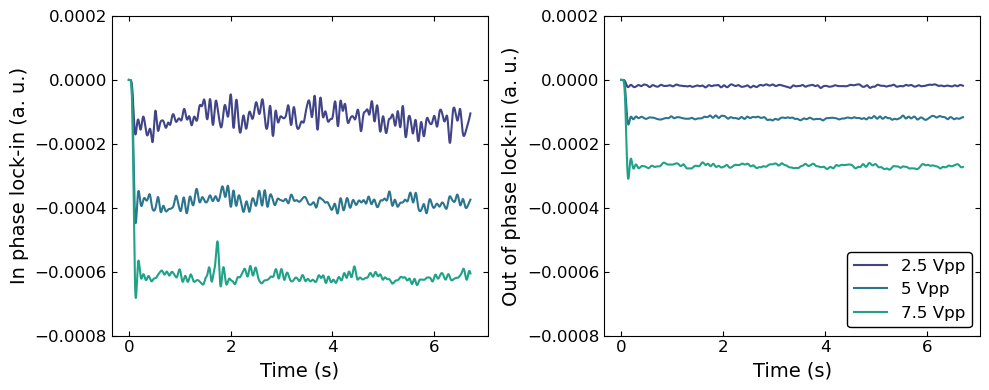

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

tt = np.arange(0, dt*zz_0.size, dt)

axes[0].plot(tt, ee_0)
axes[0].plot(tt, ee_1)
axes[0].plot(tt, ee_2)

axes[1].plot(tt, bb_0, label='2.5 Vpp')
axes[1].plot(tt, bb_1, label='5 Vpp')
axes[1].plot(tt, bb_2, label='7.5 Vpp')

for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylim(-0.0008, 0.0002)

axes[0].set_ylabel('In phase lock-in (a. u.)')
axes[1].set_ylabel('Out of phase lock-in (a. u.)')

axes[1].legend(edgecolor='k', framealpha=1, loc='lower right')
fig.tight_layout()

In [46]:
vpp   = np.array([2.5, 5, 7.5])

v_amp = vpp / 2
efield = 106            # V/m per volt
charge = 350 * 1.6e-19  # Coulomb
f_amp = v_amp * efield * charge # N

lockin_2_newtons = np.empty(3)
for i, ee in enumerate([ee_0, ee_1, ee_2]):
    lockin_2_newtons[i] = f_amp[i] / np.mean(ee[1000000:])
print(f'Lock-in to Newton factors: {lockin_2_newtons}')

lockin_2_newton = lockin_2_newtons[2]


Lock-in to Newton factors: [-6.37008180e-11 -3.89867135e-11 -3.60768102e-11]


In [233]:
lockin_2_newton


-3.6076810164602596e-11

#### Process the actual measurement data

In [51]:
fs   = 1250000
f_lp = 10

sos_filt = butter(N=8, Wn=f_lp, btype='lowpass', output='sos', fs=fs)

In [226]:
be = np.linspace(-1e-15, 1e-15, 250)
bc = 0.5 * (be[1:] + be[:-1])

hist_diff = np.zeros(bc.size, dtype=np.int64)
hist_diff_nob_0 = np.zeros(bc.size, dtype=np.int64)
hist_diff_nob_1 = np.zeros(bc.size, dtype=np.int64)

# ees_0, bbs_0 = [], []
# ees_1, bbs_1 = [], []

for i in range(500):
    if i % 50 == 0:
        print(i)
    
    _file_0 = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_midfreq/20250808_m350e_276khz_350vpp_withb_{i}.hdf5'
    _file_1 = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_midfreq/20250808_m350e_276khz_350vpp_withb_flipped_{i}.hdf5'
    _file_n = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_midfreq/20250808_m350e_276khz_350vpp_nob_{i}.hdf5'


    attrs, tts = utils.get_timestreams(file=_file_0, channels=['d', 'g'], attrs=['delta_t'])
    dt, zz_0, gg_0 = attrs[0], tts[0], tts[1]

    attrs, tts = utils.get_timestreams(file=_file_1, channels=['d', 'g'], attrs=['delta_t'])
    dt, zz_1, gg_1 = attrs[0], tts[0], tts[1]

    attrs, tts = utils.get_timestreams(file=_file_n, channels=['d', 'g'], attrs=['delta_t'])
    dt, zz_n, gg_n = attrs[0], tts[0], tts[1]

    gg_normalized_0 = normalized_drive(gg_0)
    gg_normalized_1 = normalized_drive(gg_1)
    gg_normalized_n = normalized_drive(gg_n)

    ee_0, bb_0 = get_eb_comp(dt, zz_0, gg_normalized_0, sos_filt)
    ee_1, bb_1 = get_eb_comp(dt, zz_1, gg_normalized_1, sos_filt)
    ee_n, bb_n = get_eb_comp(dt, zz_n, gg_normalized_n, sos_filt)

    _diff = get_diff_newton(ee_0, bb_0, ee_1, bb_1, lockin_2_newton)
    hh, _ = np.histogram(_diff, bins=be)
    hist_diff += hh

    _diff_0n = get_diff_newton(ee_0, bb_0, ee_n, bb_n, lockin_2_newton)
    hh_0n, _ = np.histogram(_diff_0n, bins=be)
    hist_diff_nob_0 += hh_0n

    _diff_1n = get_diff_newton(ee_1, bb_1, ee_n, bb_n, lockin_2_newton)
    hh_1n, _ = np.histogram(_diff_1n, bins=be)
    hist_diff_nob_1 += hh_1n

    # ees_0.append(ee_0)
    # bbs_0.append(bb_0)
    # ees_1.append(ee_1)
    # bbs_1.append(bb_1)


0
50
100
150
200
250
300
350
400
450


In [187]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def log_gauss(x, A, mu, sigma):
    return np.log(A * np.exp(-(x - mu)**2 / (2 * sigma**2)))

In [206]:
be = np.linspace(-1e-15, 1e-15, 250)
bc = 0.5 * (be[1:] + be[:-1])

idx_fit = np.logical_and(bc > -2e-16, bc < 2e-16)
gp, gcov = curve_fit(log_gauss, bc[idx_fit]*1e18, np.log(hist[idx_fit]), p0=[1.05e8, 0, 110], maxfev=50000)


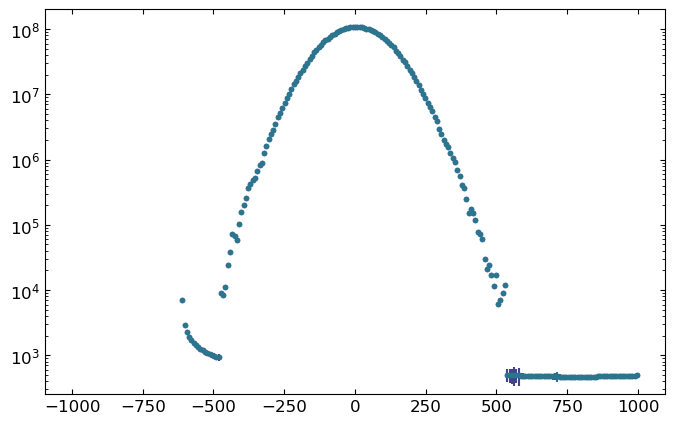

In [231]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.errorbar(bc*1e18, hist_diff, yerr=np.sqrt(hist_diff_nob_0), fmt='.')
ax.errorbar(bc*1e18, hist_diff, yerr=np.sqrt(hist_diff_nob_1), fmt='.')

ax.set_yscale('log')

Text(0, 0.5, 'Counts')

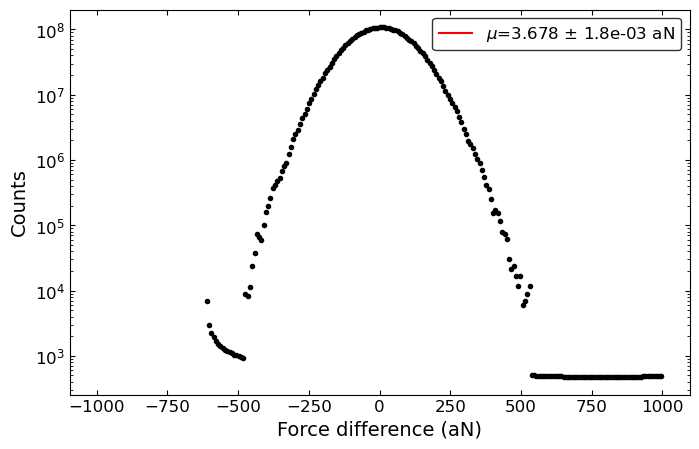

In [232]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.errorbar(bc*1e18, hist_diff, yerr=np.sqrt(hist_diff), color='k', fmt='.')
ax.plot(bc[idx_fit]*1e18, np.exp(log_gauss(bc[idx_fit]*1e18, gp[0], gp[1], gp[2])), 'r-', label=fr'$\mu$={gp[1]:.3f} $\pm$ {gp[2]/np.sqrt(np.sum(hist)):.1e} aN')

# ax.set_ylim(1, 2e8)
ax.set_yscale('log')
ax.legend(edgecolor='k')
ax.set_xlabel('Force difference (aN)')
ax.set_ylabel('Counts')